# 데이터 불러오기
- 캐글 오픈소스 데이터 : ptbdb_abnormal / ptbdb_normal 사용

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, SimpleRNN, Embedding, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [38]:
data_ab = pd.read_csv('./ptbdb_abnormal.csv')
data_no = pd.read_csv('./ptbdb_normal.csv')

In [39]:
print('data_ab.shape = ', data_ab.shape)
print('data_no.shape = ', data_no.shape)

data_ab.shape =  (10505, 188)
data_no.shape =  (4045, 188)


In [40]:
# 그래프로 나타내려면 넘파이 어레이로 바꿔야함
data_ab = np.array(data_ab)
data_no = np.array(data_no)

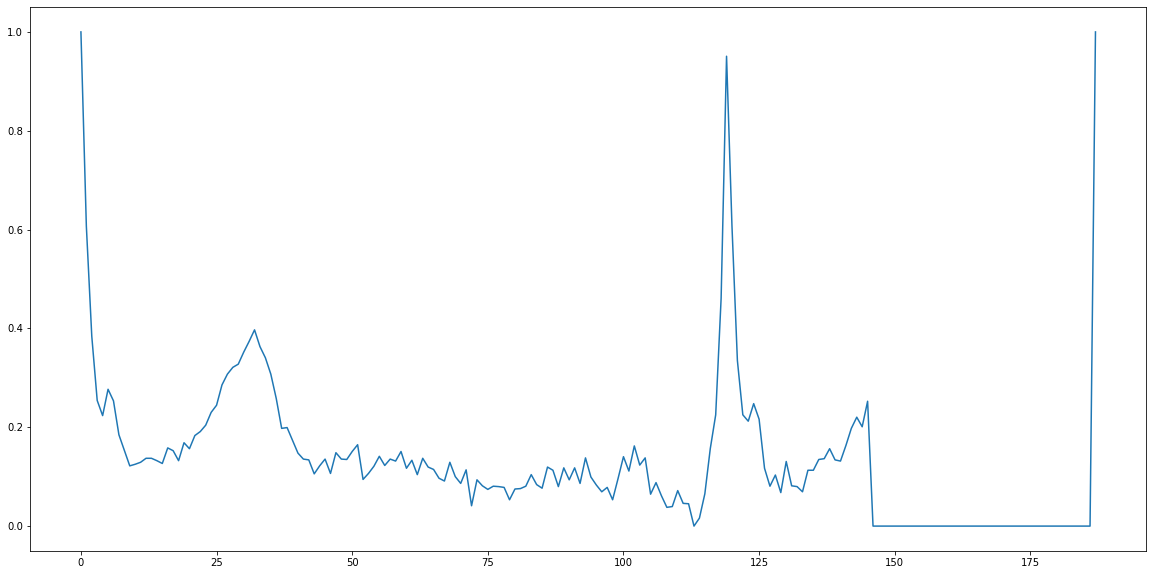

In [11]:
# 그래프를 보니 데이터가 가다가 중간에 0이 되버림
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(data_ab[0,:])

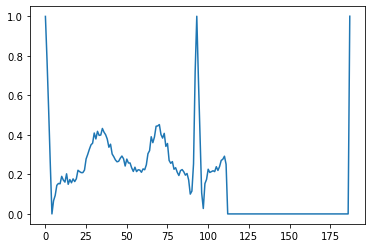

In [41]:
# 그래프를 보니 데이터가 가다가 중간에 0이 되버림
plt.plot(data_ab[5,:])

# 학습 셋, 테스트 셋

## 데이터 전부 다 사용해서 셋 나누기

In [42]:
X_train_pre = np.concatenate((data_ab[:, :-1], data_no[:, :-1]), 0)
print('X_train_pre.shape = ', X_train_pre.shape)

y = np.concatenate((data_ab[:,-1], data_no[:,-1]), 0)
print('y = ', y.shape)

X_train_pre.shape =  (14550, 187)
y =  (14550,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size=0.25)

In [44]:
print('X_train.shape = ', X_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_train.shape = ', y_train.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (10912, 187)
X_test.shape =  (3638, 187)
y_train.shape =  (10912,)
y_test.shape =  (3638,)


In [45]:
# train 데이터를 바로 컨벌션 레이어에 넣으면 에러남 : 뒤에 차원의 갯수가 모자라서
# 뒤쪽에 차원을 하나 추가해줘야함

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [52]:
print('X_train.shape = ', X_train.shape)
print('X_test.shape = ', X_test.shape)

X_train.shape =  (10912, 187, 1)
X_test.shape =  (3638, 187, 1)


In [51]:
y_train = to_categorical(y_train)
y_train[0]

array([0., 1.], dtype=float32)

In [53]:
y_test = to_categorical(y_test)
y_test[0]

In [54]:
print('y_train.shape = ', y_train.shape)
print('y_test.shape = ', y_test.shape)

y_train.shape =  (10912, 2)
y_test.shape =  (3638, 2)


## 학습용 셋 : 3000개, 테스트 셋 : 1000개

# CNN + LSTM 모델 생성

In [56]:
# 모델 디자인
# 시퀀셜 모델, 컨별선2개 맥스풀링 컨별선2개 맥스풀링 LSTM 완전연결층
# 학습율은 0.01인데 조절 가능함

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(LSTM(16))
model.add(Dense(units=2, activation='softmax'))

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 185, 16)           64        
                                                                 
 conv1d_9 (Conv1D)           (None, 183, 16)           784       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 91, 16)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 89, 32)            1568      
                                                                 
 conv1d_11 (Conv1D)          (None, 87, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 43, 32)           0         
 1D)                                                  

In [58]:
# 분류하는 모델이고 원핫인코딩 되어 있기 때문에 loss는 categorical_crossentropy 사용함
# loss : 오차 함수 = 손실 함수. 오차(예측값과 실제값의 차이)를 어떤 함수로 표현할 것인가
# optimizer : loss function의 최솟값을 찾아가는 것. 최적화 ex) 경사하강법
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [61]:
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
69/69 [==============================] - 1s 8ms/step - loss: 0.0616 - accuracy: 0.9797 - val_loss: 0.1642 - val_accuracy: 0.9455
Epoch 2/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0731 - accuracy: 0.9739 - val_loss: 0.0849 - val_accuracy: 0.9734
Epoch 3/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0615 - accuracy: 0.9800 - val_loss: 0.0944 - val_accuracy: 0.9666
Epoch 4/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0826 - accuracy: 0.9696 - val_loss: 0.1013 - val_accuracy: 0.9666
Epoch 5/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0626 - accuracy: 0.9797 - val_loss: 0.0886 - val_accuracy: 0.9675
Epoch 6/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0624 - accuracy: 0.9793 - val_loss: 0.1110 - val_accuracy: 0.9638
Epoch 7/50
69/69 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.9562 - val_loss: 0.0960 - val_accuracy: 0.9689
Epoch 8/50
69/69 [==

In [60]:
model.evaluate(X_test, y_test)

114/114 [==============================] - 1s 3ms/step - loss: 0.1046 - accuracy: 0.9651


[0.1045619547367096, 0.9650906920433044]